In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *


In [9]:
pnc = load_product("train", "PINA_COLADAS")["mid_price"]
cnt = load_product("train", "COCONUTS")["mid_price"]


In [13]:
df = pd.concat([pnc, cnt], axis=1, keys=["pnc", "cnt"])
df

,pnc,cnt
timestamp,,
0,15000.0,8000.0
100,15000.0,7999.5
200,14999.5,7998.5
300,15000.0,7999.5
400,14999.0,7998.5
...,...,...
1999500,15005.5,8002.0
1999600,15003.5,8001.0
1999700,15004.5,8001.0


In [14]:
class MyKalmanFilter:

    def __init__(self, delta=1e-4, R=1e-3):
        # measurement noise variance
        self.R = R

        # co-variance of process noise(2 dimensions)
        self.Q = delta / (1-delta) * np.eye(2)

        # state (slope, intercept) will be (2 x n), we will initialize with just one column at first
        self.x = np.zeros((2, 1))

        # state covariance
        self.P = np.zeros((2, 2))

    def step_forward(self, y1, y2):
        # Before entering the equations, let's define H as (1, 2) matrix
        H = np.array([y2, 1])[None]
        # and define z
        z = y1

        ## TIME UPDATE ##
        # first thing is to predict new state as the previous one (2x1)
        x_hat = self.x[:, -1][..., None]

        # then, the uncertainty or covariance prediction
        P_hat = self.P + self.Q

        ## MEASUREMENT UPDATE ##
        # calc the Kalman gain
        K = P_hat.dot(H.T)/(H.dot(P_hat.dot(H.T))+self.R)

        # state update part 1 (measurement estimation)
        z_hat = H.dot(x_hat)
        # state update part 2
        x = x_hat + K.dot(z-z_hat)

        # uncertainty update
        self.P = (np.eye(2)-K.dot(H)).dot(P_hat)

        # append the new state to the vector
        self.x = np.concatenate([self.x, x], axis=1)

        return x, self.P, K, z_hat


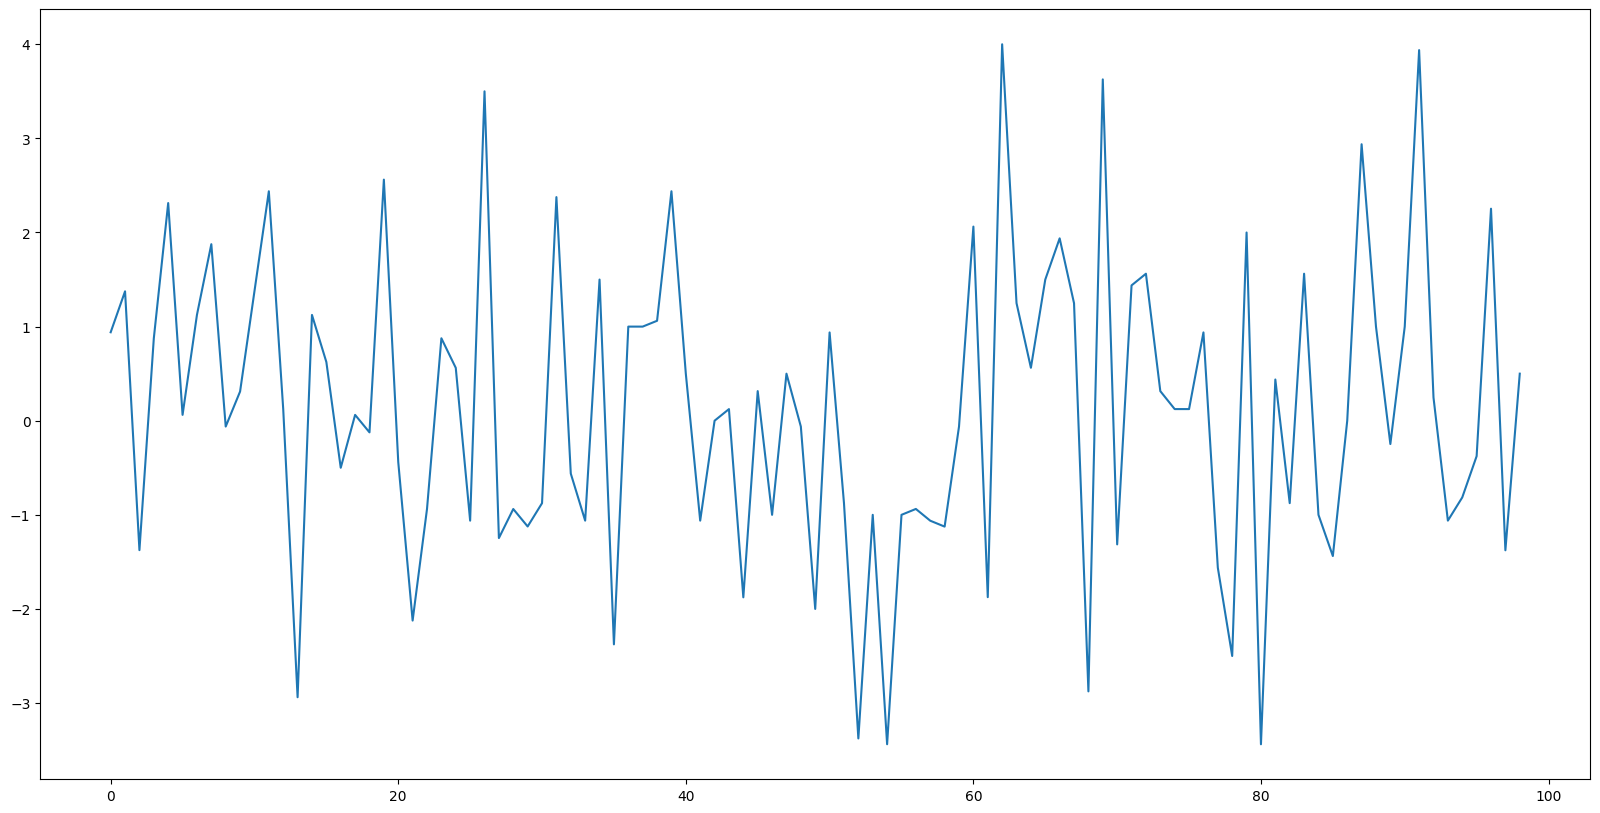

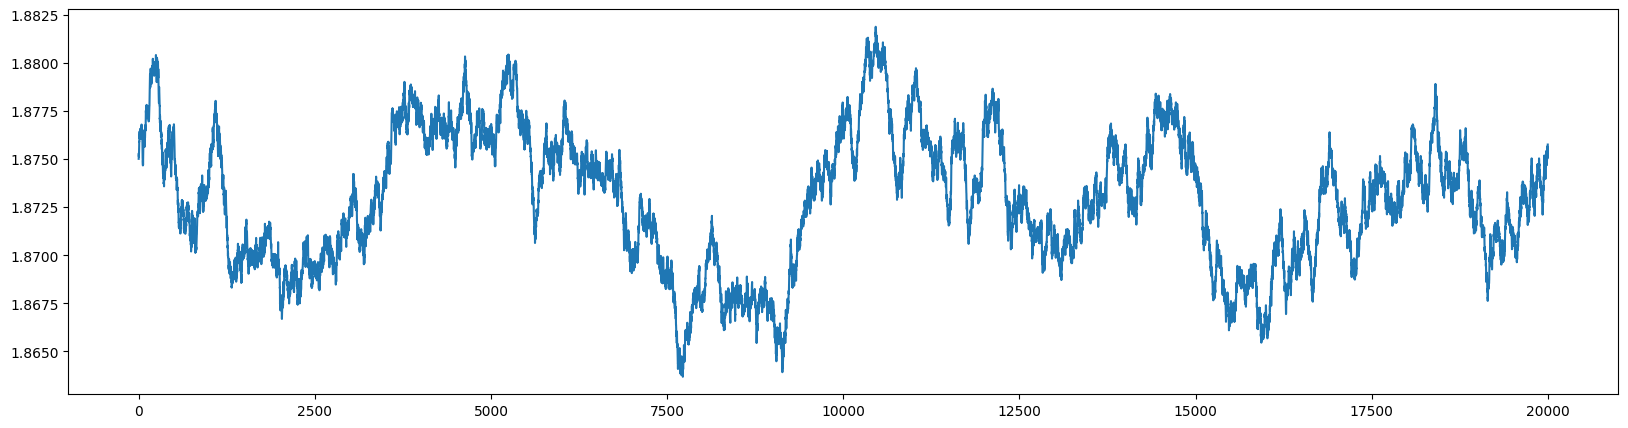

In [25]:
mkf = MyKalmanFilter(delta=1e-4, R=1e-3)
series = []
for idx, row in df.iterrows():
    x, P, K, z_hat = mkf.step_forward(row["pnc"], row["cnt"])
    series.append(row["pnc"] - z_hat.squeeze())

# Plot the combined portfolio
plt.figure(figsize=(20, 10))
plt.plot(series[1:100])

# Plot the hedge ratio over time
plt.figure(figsize=(20, 5))
plt.plot(mkf.x[0, 1:])
